In [37]:
import os
import pandas as pd
import torch
from cv2 import cv2
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from emotion import Embedder, Predictor
from face_crop import FaceCropper
from utils import MyModel
import numpy as np

MODEL = 'model.pt'
model = MyModel(n_classes=7)
model.load_state_dict(torch.load(MODEL))
embedder = Embedder(model)


def read_images():
    x = pd.read_csv('data/labels.csv')
    label_dict = dict(zip(x['filename'], x['happiness']))

    images = []
    labels = []
    fc = FaceCropper()

    for filename, label in label_dict.items():
        img = cv2.imread('data/'+filename)
        img = fc.crop_face(img)
        # convert to gray
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        img = img.astype(np.float32) / 255
        img = img[:,:,None]

        images.append(img)
        labels.append(label)
    labels = np.array(labels)
    images = np.array(images)
    return images, labels

# images, labels = read_images()
# torch.save((images, labels), 'tmp0.pth')
images, labels = torch.load('tmp0.pth')
orig = labels

assert images[0].shape[2] == 1
assert images[0].dtype == np.float32
print('loaded', len(images), 'images')
print('image shape:', images[0].shape)


loaded 78 images
image shape: (315, 315, 1)


In [52]:
import importlib
import emotion
importlib.reload(emotion)


from sklearn.metrics import mean_squared_error
images = np.array(images)
labels = np.sign(orig)
labels[labels == 0] = -1
# labels = orig

train_score = []
test_score = []

kf = KFold(n_splits=3, shuffle=True)
for train_index, test_index in kf.split(images):
    images_train, images_test = images[train_index], images[test_index]
    labels_train, labels_test = labels[train_index], labels[test_index]
    regressor = KNeighborsRegressor(n_neighbors=10, metric='cosine')
    # regressor = LinearRegression()
    # regressor = Ridge()
    # regressor = DecisionTreeRegressor(max_depth=3)
    # regressor = LogisticRegression()
    predictor = Predictor(embedder, regressor, labels_train, images=images_train)

    train_pred = predictor.get_happiness(images_train)
    train_score.append(mean_squared_error(labels_train, train_pred))
    print('train mse:', train_score[-1])
    test_pred  = predictor.get_happiness(images_test)
    test_score.append(mean_squared_error(labels_test, test_pred))
    print('test mse:', test_score[-1])

print('train mean accuracy:', np.mean(train_score))
print('test mean accuracy:', np.mean(test_score))

train mse: 0.5384615384615385
test mse: 0.7430769230769232
train mse: 0.6207692307692307
test mse: 0.5169230769230769
train mse: 0.5876923076923077
test mse: 0.7523076923076923
train mean accuracy: 0.5823076923076923
test mean accuracy: 0.6707692307692309


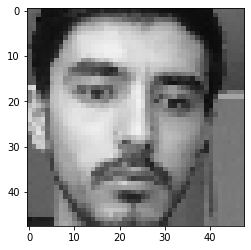

In [39]:
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import transforms as AT


T = A.Compose([
    A.Resize(48, 48, interpolation=cv2.INTER_LINEAR),
    AT.ToTensor(),
])

img = images[0].copy()
assert img.shape[2] == 1, img.shape
img = T(image=img)['image'].expand(3, -1, -1)
assert img.shape == (3,48,48), img.shape

plt.imshow(img.numpy().transpose(1, 2, 0))
# or embedder
plt.imshow(embedder.transform(images[0]).numpy().transpose(1, 2, 0))

## TRAIN

In [57]:
# create training set
myimages = []
t = A.Resize(48,48)
for img in images:
    img = t(image=img)['image']
    myimages.append(img)
myimages = np.stack(myimages, axis=0)
print(myimages.shape, myimages.dtype)

torch.save((myimages, orig), 'myimages.pt')

(78, 48, 48, 1) float32


In [46]:
emb = embedder.get_embeddings(images)
with torch.no_grad():
    model_predictions = model.output(emb)
    model_predictions = torch.argmax(model_predictions, dim=1)

Counter(model_predictions.tolist())

Counter({6: 67, 4: 1, 5: 1, 3: 7, 2: 2})

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1,  2,  2, -2,  2,  2,  2,  2,  2,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  0, -1, -2,
       -2, -2,  0,  0, -1, -2, -2, -2, -2, -2, -1, -1,  0, -1, -1, -1, -2,
       -2, -2, -1, -1, -1, -1, -1,  0,  0, -1])